In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primaldual_VPINN import *
from PDE_losses import compute_int
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

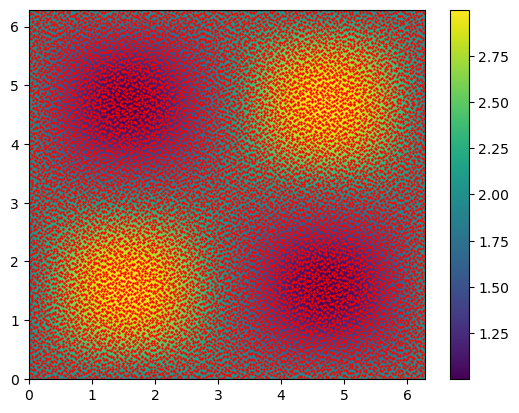

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = 2+np.sin(x)*np.sin(y)
    return a

def A(x):  
    a = (2+torch.sin(x[:,0])*torch.sin(x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [4]:
def eig_func(x, m, n, p1, p2):
    z = torch.sin(m*x[:,0]+p1*torch.pi/2)*torch.sin(n*x[:,1]+p2*torch.pi/2)
    return z

N_test = 2
test_functions = []

for m in range(N_test):
    for n in range(N_test):
        for p1 in range(2):
            for p2 in range(2):
                test_functions.append(lambda x, m=m+1, n=n+1, p1=p1, p2=p2: eig_func(x, m, n, p1, p2))

G = 1/torch.pi**2 * torch.eye(len(test_functions),device=dev)

In [5]:
N_test = 75
torch.manual_seed(0)
test_functions = [PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L).to(dev) for i in range(N_test)]
G = torch.load("G.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G)

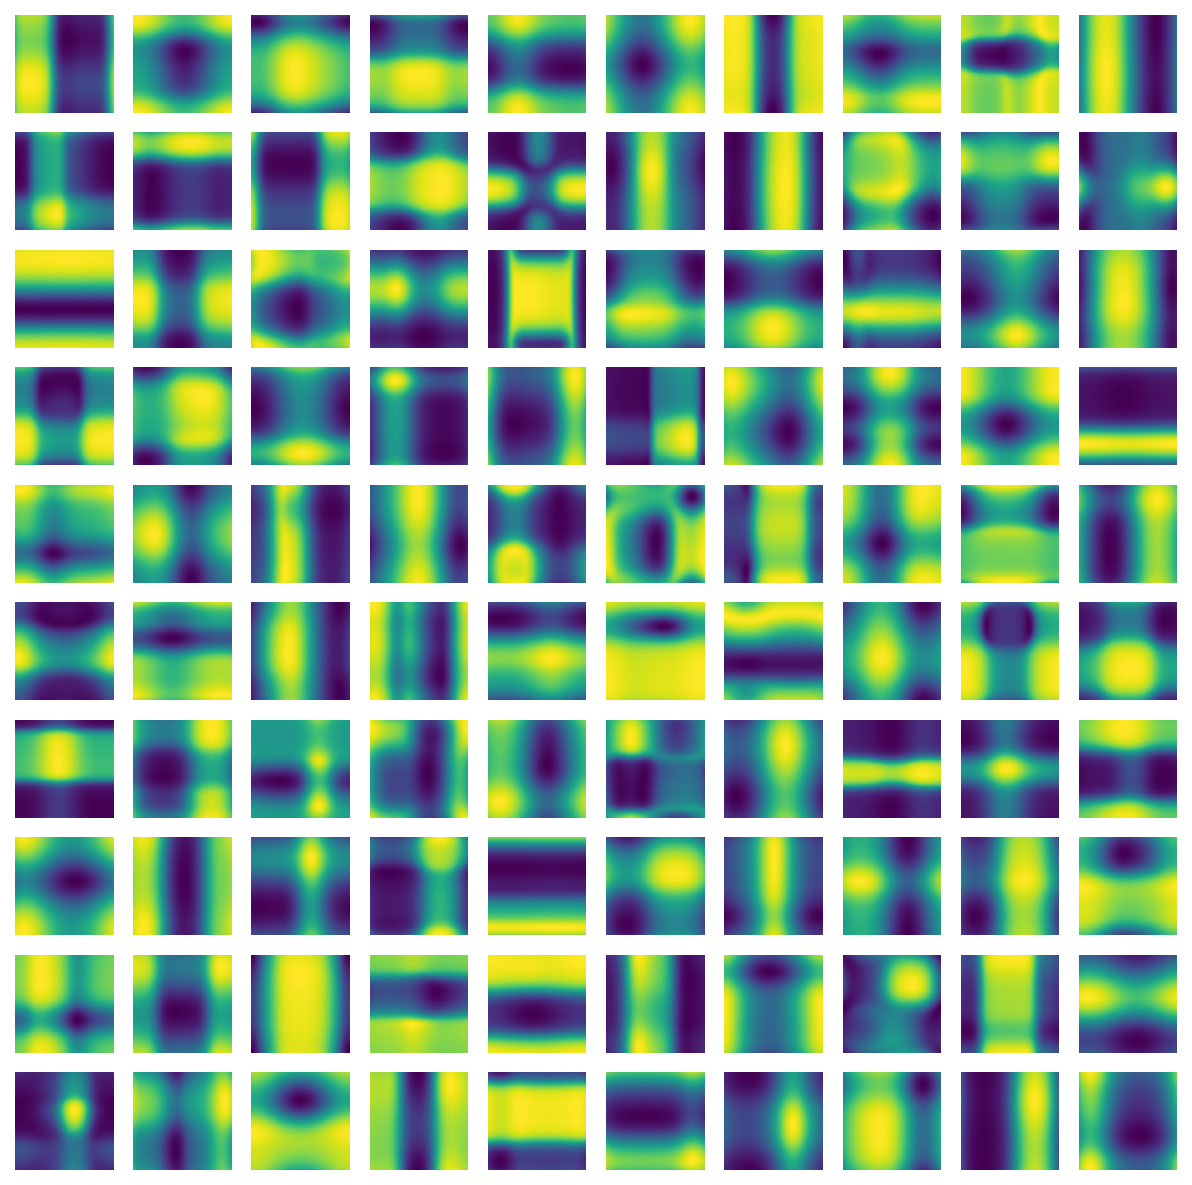

In [8]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

In [17]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
elem = tri.triangles

G = torch.zeros((N_test, N_test))
for i in range(N_test):
    y_1 = test_functions[i](x.to(dev)).detach()
    for j in range(i, N_test):
        y_2 = test_functions[j](x.to(dev)).detach()
        f_tri = y_1[elem]
        test_tri = y_2[elem]
        prod = f_tri * test_tri
        prod_mean = prod.mean(dim=1)
        tri_int = areas * prod_mean
        intgr = tri_int.sum()
        G[i,j] = intgr
        G[j,i] = intgr

torch.save(G, "G.pt")

In [6]:
net_H1 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 10000, 'dev' : dev, 'name' : f'NN_library/VPINN/VPINN_H1_{total_params}_sin'}

Number of parameters: 65


In [18]:
net_H1 = load_network(net_H1, args['name']+'_9999', args)
net_H1 = net_H1.to(dev)

In [105]:
net_H1 = load_network(net_H1, f'NN_library/PINN/PINN_H1_{total_params}_sin'+'_9999', args)
net_H1 = net_H1.to(dev)

In [ ]:
losses_train, losses_train_ref, losses_val = train(net_H1, loaders, args, A , H1, test_functions, G_inv, L)

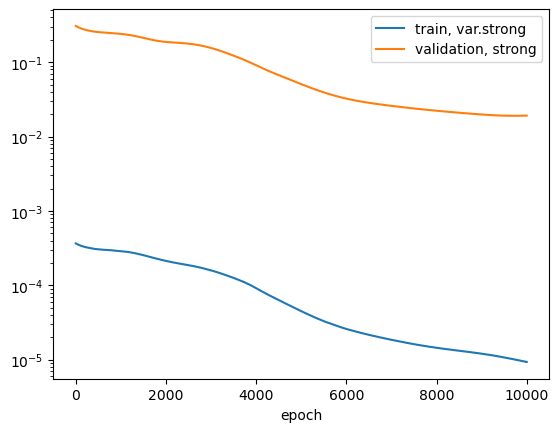

In [9]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train, var.strong', 'validation, strong'])
plt.yscale('log')

In [10]:
np.save(f'NN_library/training_data/VPINN_H1_{total_params}_1', np.array(losses_train))

In [11]:
U1 = net_H1(grid_data).detach().cpu()
error_1 = PDE_loss(grid_data, net_H1, A, H1).detach().cpu()

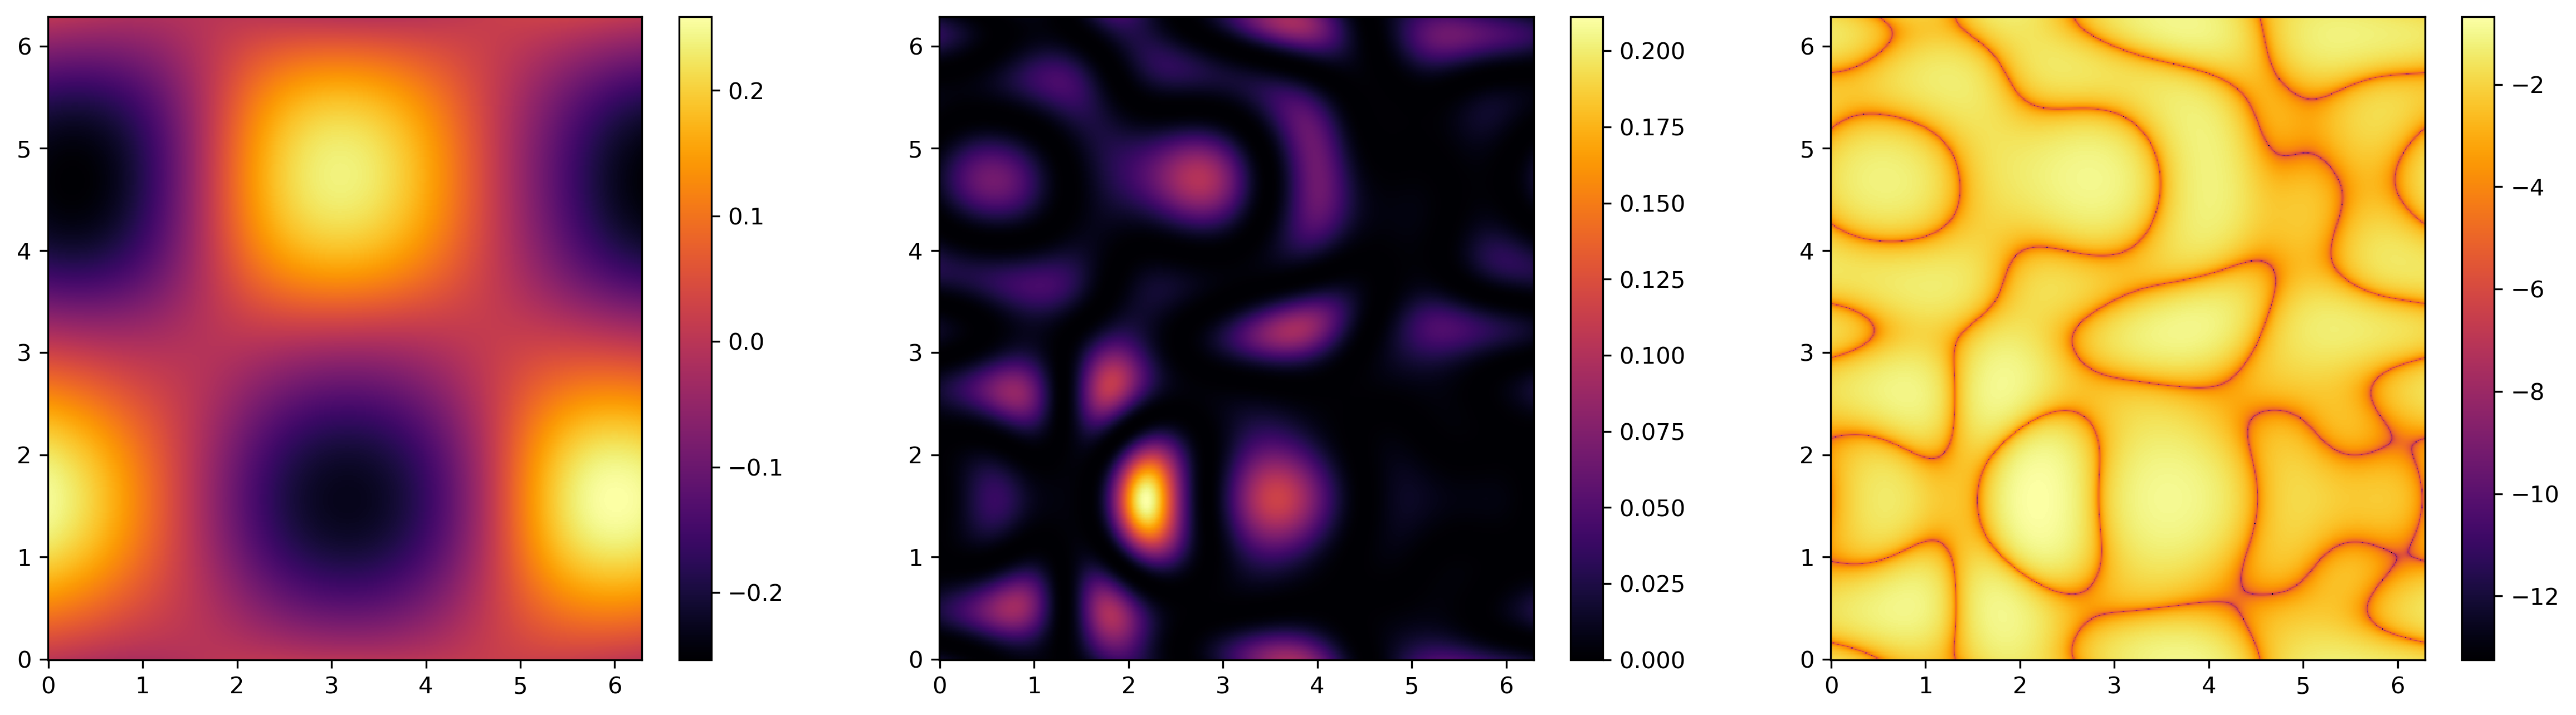

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [13]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1)
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])

In [15]:
A_bound = compute_bound(T1, dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[1.93809902e+00]
 [3.79262634e-05]]
[[ 1.98506662e+00]
 [-8.11754153e-04]]


In [40]:
A_avg = compute_avg(dq1, inputs, A, H1, L)
print(A_avg/2)

[2.9998798e+00 1.3648366e-04]
